In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [5]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [14]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [15]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

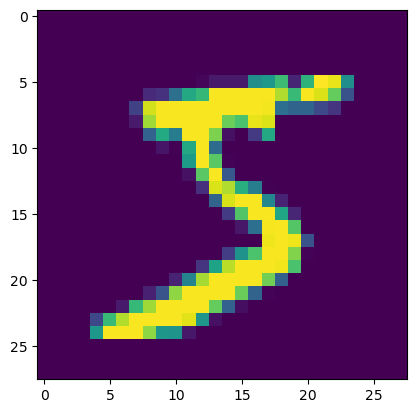

In [16]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [222]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [223]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [224]:
train(model, optimizer)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 477.14it/s]


Epoch: 0, loss: 0.32221439480781555, accuracy: 0.9107


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 486.20it/s]


Epoch: 2, loss: 0.22897681593894958, accuracy: 0.9344


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 485.84it/s]

Epoch: 4, loss: 0.18462838232517242, accuracy: 0.9463


In [120]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(360, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

print(f"Модель 1 параметров: {count_parameters(model)}")

Модель 1 параметров: 47758


In [121]:
train(model, optimizer)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 334.59it/s]


Epoch: 0, loss: 0.22071079909801483, accuracy: 0.9397


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 358.59it/s]


Epoch: 2, loss: 0.11386488378047943, accuracy: 0.9665


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 349.83it/s]

Epoch: 4, loss: 0.0803009569644928, accuracy: 0.9759


1) SGD с Momentum - Сразу побил скор 0.9882
2)Adam - c Lr = 0.01: дает Accuracy = 0.9793
3)Adam - c Lr = 0.001: дает Accuracy = 0.9869
4) AdamW - c Lr = 0.001: дает Accuracy = 0.986

колво параметров для kernel_size = 3 - 47598
для 5 - 47758
для 4 - 47668
для 2 - 47548

In [174]:
model_mse = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer_mse = torch.optim.SGD(model_mse.parameters(), lr=0.01)

In [175]:
def train_MSE(model_mse, optimizer_mse, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model_mse(x_train)
            loss = F.mse_loss(F.softmax(y_pred, dim=-1), F.one_hot(y_train, num_classes=10).float())
            loss.backward()
            optimizer_mse.step()
            optimizer_mse.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model_mse(x_val)
                    loss = F.mse_loss(F.softmax(y_pred, dim=-1), F.one_hot(y_val, num_classes=10).float())
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [176]:
train_MSE(model_mse, optimizer_mse)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 487.42it/s]


Epoch: 0, loss: 0.079658143222332, accuracy: 0.4697


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 480.89it/s]


Epoch: 2, loss: 0.047049425542354584, accuracy: 0.742


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 480.45it/s]

Epoch: 4, loss: 0.029066674411296844, accuracy: 0.8563


In [177]:
model_mse = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer_mse = torch.optim.SGD(model_mse.parameters(), lr=0.01)

In [178]:
train_MSE(model_mse, optimizer_mse)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 353.18it/s]


Epoch: 0, loss: 0.08836696296930313, accuracy: 0.2559


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 352.47it/s]


Epoch: 2, loss: 0.0824488177895546, accuracy: 0.4959


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 350.74it/s]

Epoch: 4, loss: 0.05756786838173866, accuracy: 0.6673


Mse - дает хорошую точность, если выбран оптимизатор ADAM - точность получилась даже немного выше кросс энтропи в отдельных случаях,  а вот в паре с SGD дает плохие результаты

In [217]:
model_NL = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer_NL = torch.optim.Adam(model_NL.parameters(), lr=0.001)

In [218]:
def train_NLL(model_NL, optimizer_NL, n_epochs=5):
    for epoch in range(n_epochs):
        for x_train, y_train in tqdm(train_dataloader):
            y_pred_logits = model_NL(x_train)
            y_pred_log_probs = F.log_softmax(y_pred_logits, dim=1)
            loss = F.nll_loss(y_pred_log_probs, y_train)
            loss.backward()
            optimizer_NL.step()
            optimizer_NL.zero_grad()

        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred_logits = model_NL(x_val)
                    val_accuracy.extend((torch.argmax(y_pred_logits, dim=-1) == y_val).numpy().tolist())
                    loss = F.nll_loss(F.log_softmax(y_pred_logits, dim=1), y_val)
                    val_loss.append(loss.numpy())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [219]:
train_NL(model_NL, optimizer_NL)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 467.78it/s]


Epoch: 0, loss: 0.14311480522155762, accuracy: 0.956


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 468.48it/s]


Epoch: 2, loss: 0.08392651379108429, accuracy: 0.9761


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 468.10it/s]

Epoch: 4, loss: 0.07437309622764587, accuracy: 0.9788


In [159]:
model_NL = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer_NL = torch.optim.Adam(model_NL.parameters(), lr=0.001)

In [160]:
train_NL(model_NL, optimizer_NL)

100%|████████████████████████████████████████| 157/157 [00:00<00:00, 355.17it/s]


Epoch: 0, loss: 0.08470558375120163, accuracy: 0.974


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 350.76it/s]


Epoch: 2, loss: 0.05123662203550339, accuracy: 0.9835


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 356.48it/s]

Epoch: 4, loss: 0.06190171837806702, accuracy: 0.9823


NLLloss - дает довольно хорошие результаты, как и кросс энтропия за счет того, что кросс энтропия можно сказать полностью повторяет то, что написано выше: применяет функцию softmax, а потом применяет NLLLoss


 10_f_k5
Кол-во параметров: 47758


10_f_k5 Epoch 0: 100%|███████████████████████| 938/938 [00:04<00:00, 205.12it/s]


10_f_k5 Epoch 0: Train Loss: 0.6238, Val Loss: 0.2136, Val accuracy: 0.9370


10_f_k5 Epoch 1: 100%|███████████████████████| 938/938 [00:04<00:00, 206.74it/s]


10_f_k5 Epoch 1: Train Loss: 0.1870, Val Loss: 0.1405, Val accuracy: 0.9580


10_f_k5 Epoch 2: 100%|███████████████████████| 938/938 [00:04<00:00, 201.50it/s]


10_f_k5 Epoch 2: Train Loss: 0.1387, Val Loss: 0.1103, Val accuracy: 0.9670


10_f_k5 Epoch 3: 100%|███████████████████████| 938/938 [00:04<00:00, 201.93it/s]


10_f_k5 Epoch 3: Train Loss: 0.1143, Val Loss: 0.1007, Val accuracy: 0.9700


10_f_k5 Epoch 4: 100%|███████████████████████| 938/938 [00:04<00:00, 206.18it/s]


10_f_k5 Epoch 4: Train Loss: 0.0985, Val Loss: 0.0837, Val accuracy: 0.9744


10_f_k5 Epoch 5: 100%|███████████████████████| 938/938 [00:04<00:00, 205.63it/s]


10_f_k5 Epoch 5: Train Loss: 0.0873, Val Loss: 0.0844, Val accuracy: 0.9737


10_f_k5 Epoch 6: 100%|███████████████████████| 938/938 [00:04<00:00, 206.10it/s]


10_f_k5 Epoch 6: Train Loss: 0.0791, Val Loss: 0.0721, Val accuracy: 0.9761

 32_f_k3
Кол-во параметров: 149194


32_f_k3 Epoch 0: 100%|███████████████████████| 938/938 [00:06<00:00, 135.02it/s]


32_f_k3 Epoch 0: Train Loss: 0.5318, Val Loss: 0.2310, Val accuracy: 0.9331


32_f_k3 Epoch 1: 100%|███████████████████████| 938/938 [00:07<00:00, 131.03it/s]


32_f_k3 Epoch 1: Train Loss: 0.1967, Val Loss: 0.1475, Val accuracy: 0.9582


32_f_k3 Epoch 2: 100%|███████████████████████| 938/938 [00:07<00:00, 128.98it/s]


32_f_k3 Epoch 2: Train Loss: 0.1404, Val Loss: 0.1108, Val accuracy: 0.9685


32_f_k3 Epoch 3: 100%|███████████████████████| 938/938 [00:07<00:00, 132.20it/s]


32_f_k3 Epoch 3: Train Loss: 0.1123, Val Loss: 0.1016, Val accuracy: 0.9699


32_f_k3 Epoch 4: 100%|███████████████████████| 938/938 [00:06<00:00, 134.21it/s]


32_f_k3 Epoch 4: Train Loss: 0.0952, Val Loss: 0.0808, Val accuracy: 0.9757


32_f_k3 Epoch 5: 100%|███████████████████████| 938/938 [00:07<00:00, 132.62it/s]


32_f_k3 Epoch 5: Train Loss: 0.0843, Val Loss: 0.0779, Val accuracy: 0.9759


32_f_k3 Epoch 6: 100%|███████████████████████| 938/938 [00:06<00:00, 134.31it/s]


32_f_k3 Epoch 6: Train Loss: 0.0760, Val Loss: 0.0665, Val accuracy: 0.9788

 64_f_k3
Кол-во параметров: 593290


64_f_k3 Epoch 0: 100%|████████████████████████| 938/938 [00:10<00:00, 89.27it/s]


64_f_k3 Epoch 0: Train Loss: 0.4730, Val Loss: 0.2261, Val accuracy: 0.9364


64_f_k3 Epoch 1: 100%|████████████████████████| 938/938 [00:10<00:00, 87.12it/s]


64_f_k3 Epoch 1: Train Loss: 0.1835, Val Loss: 0.1583, Val accuracy: 0.9544


64_f_k3 Epoch 2: 100%|████████████████████████| 938/938 [00:10<00:00, 87.82it/s]


64_f_k3 Epoch 2: Train Loss: 0.1295, Val Loss: 0.1036, Val accuracy: 0.9711


64_f_k3 Epoch 3: 100%|████████████████████████| 938/938 [00:11<00:00, 84.15it/s]


64_f_k3 Epoch 3: Train Loss: 0.1027, Val Loss: 0.0869, Val accuracy: 0.9750


64_f_k3 Epoch 4: 100%|████████████████████████| 938/938 [00:10<00:00, 87.46it/s]


64_f_k3 Epoch 4: Train Loss: 0.0873, Val Loss: 0.0807, Val accuracy: 0.9756


64_f_k3 Epoch 5: 100%|████████████████████████| 938/938 [00:10<00:00, 89.21it/s]


64_f_k3 Epoch 5: Train Loss: 0.0764, Val Loss: 0.0715, Val accuracy: 0.9765


64_f_k3 Epoch 6: 100%|████████████████████████| 938/938 [00:10<00:00, 89.57it/s]


64_f_k3 Epoch 6: Train Loss: 0.0693, Val Loss: 0.0989, Val accuracy: 0.9666

 16_f_k7
Кол-во параметров: 53418


16_f_k7 Epoch 0: 100%|███████████████████████| 938/938 [00:05<00:00, 156.47it/s]


16_f_k7 Epoch 0: Train Loss: 0.5240, Val Loss: 0.1744, Val accuracy: 0.9490


16_f_k7 Epoch 1: 100%|███████████████████████| 938/938 [00:05<00:00, 159.46it/s]


16_f_k7 Epoch 1: Train Loss: 0.1479, Val Loss: 0.1144, Val accuracy: 0.9665


16_f_k7 Epoch 2: 100%|███████████████████████| 938/938 [00:06<00:00, 156.29it/s]


16_f_k7 Epoch 2: Train Loss: 0.1077, Val Loss: 0.0928, Val accuracy: 0.9734


16_f_k7 Epoch 3: 100%|███████████████████████| 938/938 [00:06<00:00, 155.89it/s]


16_f_k7 Epoch 3: Train Loss: 0.0890, Val Loss: 0.0759, Val accuracy: 0.9785


16_f_k7 Epoch 4: 100%|███████████████████████| 938/938 [00:05<00:00, 160.06it/s]


16_f_k7 Epoch 4: Train Loss: 0.0774, Val Loss: 0.0652, Val accuracy: 0.9798


16_f_k7 Epoch 5: 100%|███████████████████████| 938/938 [00:06<00:00, 152.48it/s]


16_f_k7 Epoch 5: Train Loss: 0.0688, Val Loss: 0.0644, Val accuracy: 0.9805


16_f_k7 Epoch 6: 100%|███████████████████████| 938/938 [00:06<00:00, 154.21it/s]


16_f_k7 Epoch 6: Train Loss: 0.0627, Val Loss: 0.0560, Val accuracy: 0.9821


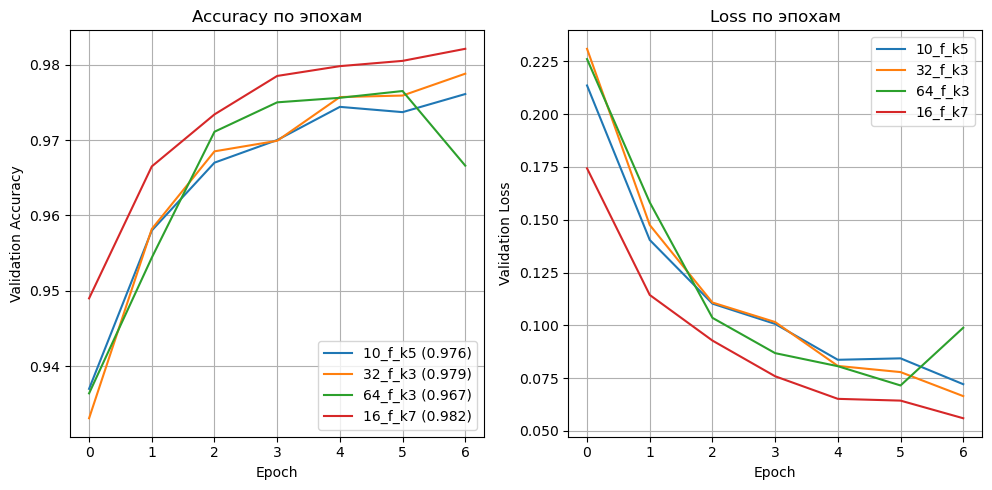


 Лучшая модель: 16_f_k7
 Accuracy: 0.9821
 Кол-во параметров: 53418
 Разница с базовой моделью: 0.0074


In [230]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_with_logging(model, optimizer, n_epochs=5, model_name="model"):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(n_epochs):
        # обучение
        epoch_train_loss = []
        for x_train, y_train in tqdm(train_dataloader, desc=f"{model_name} Epoch {epoch}"):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_loss.append(loss.item())

        # валидация
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.item())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

        train_losses.append(np.mean(epoch_train_loss))
        val_losses.append(np.mean(val_loss))
        val_accuracies.append(np.mean(val_accuracy))
        
        print(f'{model_name} Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val accuracy: {val_accuracies[-1]:.4f}')
    
    return train_losses, val_losses, val_accuracies

experiments = {}

# 1
model1 = nn.Sequential(
    nn.Conv2d(1, 10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(4),
    nn.Flatten(),
    nn.Linear(360, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)
experiments['10_f_k5'] = {'model': model1, 'optimizer': optimizer1}

# 2
model2 = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(4),
    nn.Flatten(),
    nn.Linear(32*6*6, 128),  # (28-3+1)/4 = 6.5 ---> 6
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)
experiments['32_f_k3'] = {'model': model2, 'optimizer': optimizer2}

# 3
model3 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(4),
    nn.Flatten(),
    nn.Linear(64*6*6, 256), # (28-3+1)/4 = 6.5 ---> 6
    nn.ReLU(),
    nn.Linear(256, 10)
)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=0.01)
experiments['64_f_k3'] = {'model': model3, 'optimizer': optimizer3}

# 4
model4 = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=7),
    nn.ReLU(),
    nn.MaxPool2d(4),
    nn.Flatten(),
    nn.Linear(16*5*5, 128),  # (28-7+1)/4 = 5.5 ---> 5
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer4 = torch.optim.SGD(model4.parameters(), lr=0.01)
experiments['16_f_k7'] = {'model': model4, 'optimizer': optimizer4}


results = {}
for name, exp in experiments.items():
    print(f"\n {name}")
    print(f"Кол-во параметров: {count_parameters(exp['model'])}")
    
    train_loss, val_loss, val_acc = train_with_logging(exp['model'], exp['optimizer'], n_epochs=7, model_name=name)
    
    results[name] = {
        'train_loss': train_loss,
        'val_loss': val_loss, 
        'val_acc': val_acc,
        'params': count_parameters(exp['model']),
        'final_acc': val_acc[-1]
    }

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for name, res in results.items():
    plt.plot(res['val_acc'], label=f"{name} ({res['final_acc']:.3f})")
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy по эпохам')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
for name, res in results.items():
    plt.plot(res['val_loss'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Loss по эпохам')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_model = max(results.items(), key=lambda x: x[1]['final_acc'])
print(f"\n Лучшая модель: {best_model[0]}")
print(f" Accuracy: {best_model[1]['final_acc']:.4f}")
print(f" Кол-во параметров: {best_model[1]['params']}")
print(f" Разница с базовой моделью: {best_model[1]['final_acc'] - 0.9747:.4f}")

Модели 10_f_k5, 32_f_k3, 64_f_k3 - показали склонность к переобучению на 3 - 5 эпохах 

Выводы: 64_f_k3 (593K параметров) показала результаты хуже, чем 16_f_k7 (53K параметров) - это говорит о том, что самая лучшая модель не та, где куча параметров

16_f_k7 с ядром 7×7 оказалась лучшей потому что:

Достаточно большие ядра захватывают полезные фичи для MNIST
Умеренное количество параметров предотвращает переобучение
В общем и целом получился хороший баланс между скоростью обучения и качеством.

И даже скорость обработки данных ближе всего к среднему, обычно это и есть показатель качества, как сказал ГПТ) - но иногда модель 64_f_k3 побеждает, когда не улетает в переобучение, вверху яркий пример, когда улетела

152.92it/s / 80.63it/s / 123.17it/s / 206.10it/sit/s

16_f_k7   /  64_f_k3  /  32_f_k3   /  10_f_k5
